In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import sweetviz as sv
import HelperFunctions as hf
import os 
import tarfile
import zipfile


# Overview

[M5 forecasting challenge](https://www.kaggle.com/c/m5-forecasting-accuracy/data)


## Data Description

- `calendar.csv` - Contains information about the dates on which the products are sold.

- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`

- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

- `sample_submission.csv` - The correct format for submissions. Reference the [Evaluation](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation) tab for more info.

- `sales_train_evaluation.csv` - Includes sales `[d_1 - d_1941]` (labels used for the Public leaderboard)


## Task

- Forecast daily sales for the next 28 days



# 1. Download the Data

In [9]:
%%bash

kaggle competitions download m5-forecasting-accuracy -p data


100%|██████████| 45.8M/45.8M [02:19<00:00, 343kB/s] 


In [10]:
def fetch_walmat_data():
    zip_path = os.path.join('data', 'm5-forecasting-accuracy.zip')    
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    print(zip_ref.namelist())

fetch_walmat_data()


['calendar.csv', 'sales_train_evaluation.csv', 'sales_train_validation.csv', 'sample_submission.csv', 'sell_prices.csv']


# 2. Read the Data

In [11]:
def load_calendar_data():    
    csv_path = os.path.join('data', 'calendar.csv')
    return pd.read_csv(csv_path)


def load_sell_price_data():
    csv_path = os.path.join('data', 'sell_prices.csv')
    return pd.read_csv(csv_path)


def load_sales_train_validation_data():
    csv_path = os.path.join('data', 'sales_train_validation.csv')
    return pd.read_csv(csv_path)


def load_sales_train_evaluation_data():
    csv_path = os.path.join('data', 'sales_train_evaluation.csv')
    return pd.read_csv(csv_path)


## 2.1 Read Calendar

In [12]:
calendar = load_calendar_data()
calendar.head()


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [13]:
print(f'shape: {calendar.shape}\n')

calendar.info()

shape: (1969, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


### Sweetviz

In [22]:
# quick eda by sweetViz
calendar_report = sv.analyze(calendar)

# display the report
calendar_report.show_html('Calendar.html')



Report Calendar.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Create the melted dataframe for further analysis

In [14]:
#Read data files
price_df = load_sell_price_data()
sales_df = load_sales_train_evaluation_data()

In [15]:
#Create the melted dataframe
df = hf.meltM5(sales_df, days = 730, items = 15000)

In [16]:
#Join with calendar and price data
df = hf.joinDataSets(df, calendar, price_df, dropPriceNA=False)

Initial inspection of the raw data

In [17]:
df.shape

(10950000, 22)

In [18]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_162_TX_3_evaluation,HOBBIES_1_162,HOBBIES_1,HOBBIES,TX_3,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,FOODS_2_317_WI_1_evaluation,FOODS_2_317,FOODS_2,FOODS,WI_1,WI,d_1,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,11.68
2,FOODS_1_022_WI_2_evaluation,FOODS_1_022,FOODS_1,FOODS,WI_2,WI,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,FOODS_2_159_WI_2_evaluation,FOODS_2_159,FOODS_2,FOODS,WI_2,WI,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_348_CA_3_evaluation,HOBBIES_1_348,HOBBIES_1,HOBBIES,CA_3,CA,d_1,37,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.46


In [19]:
df.describe()

,sold,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,1.095000e+07,1.095000e+07,1.095000e+07,1.095000e+07,1.095000e+07,1.095000e+07,1.095000e+07,1.095000e+07,6.364247e+06
mean,9.639409e-01,1.117684e+04,3.993151e+00,6.527397e+00,2.011575e+03,3.287671e-01,3.287671e-01,3.287671e-01,4.370622e+00
std,3.815706e+00,5.253698e+01,2.001700e+00,3.445854e+00,5.641774e-01,4.697652e-01,4.697652e-01,4.697652e-01,3.226665e+00
min,0.000000e+00,1.110100e+04,1.000000e+00,1.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-02
25%,0.000000e+00,1.112700e+04,2.000000e+00,4.000000e+00,2.011000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
50%,0.000000e+00,1.120100e+04,4.000000e+00,7.000000e+00,2.012000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.480000e+00
75%,1.000000e+00,1.122700e+04,6.000000e+00,1.000000e+01,2.012000e+03,1.000000e+00,1.000000e+00,1.000000e+00,5.880000e+00
max,4.800000e+02,1.130100e+04,7.000000e+00,1.200000e+01,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00,6.146000e+01


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10950000 entries, 0 to 10949999
Data columns (total 22 columns):
id              object
item_id         object
dept_id         object
cat_id          object
store_id        object
state_id        object
d               object
sold            int64
date            object
wm_yr_wk        int64
weekday         object
wday            int64
month           int64
year            int64
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA         int64
snap_TX         int64
snap_WI         int64
sell_price      float64
dtypes: float64(1), int64(8), object(13)
memory usage: 1.9+ GB


In [21]:
#These are likely seasonal products, such as xmas trees, or brussel sprouts
print("Percentage of products that are not on sale: ", df['sell_price'].isna().sum() / len(df['sell_price']) * 100)

Percentage of products that are not on sale:  41.87902283105023


In [28]:
###Finding yearly trends for different product categories
group = df[['cat_id','d','sold']].groupby(['cat_id','d'], as_index=False).sum()

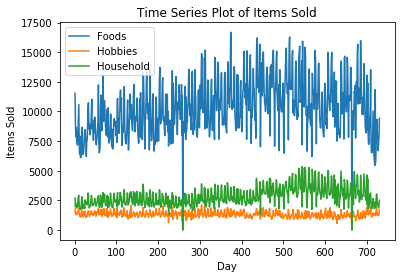

In [47]:
foods = np.array(group[group['cat_id']=='FOODS']['sold'])
hobbies = np.array(group[group['cat_id']=='HOBBIES']['sold'])
households = np.array(group[group['cat_id']=='HOUSEHOLD']['sold'])
days = np.array(list(range(1, 731)))

plt.plot(days, foods, label='Foods')
plt.plot(days, hobbies, label='Hobbies')
plt.plot(days, households, label='Household')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Items Sold')
plt.title('Time Series Plot of Items Sold')
plt.show()